In [90]:
#!pip install "gymnasium[toy-text]"
!pip install imageio


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [71]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import torch
import os
from datetime import datetime
import pickle
import io

env = gym.make("FrozenLake-v1", render_mode="rgb_array")
q_table = None
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [93]:
import imageio

def visualize_agent(env, q_table, episodes=5, sleep_time=0.5, end_sleep_time=2, video_fps=10):
    os.makedirs("results", exist_ok=True)
    completed_count = 0

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        frames = []  # To store frames for video

        while not done:
            clear_output(wait=True)

            frame = env.render()
            frames.append(frame)  # Save for potential video

            plt.imshow(frame)
            plt.axis('off')
            plt.title(f"Episode {ep+1}")
            plt.show()
            sleep(sleep_time)

            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)

        # Show final frame
        clear_output(wait=True)
        frame = env.render()
        frames.append(frame)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f"Episode {ep+1} End")
        plt.show()
        sleep(end_sleep_time)

        # Save only if agent reached the goal
        if state == 15:
            completed_count += 1

            # Generate timestamped filenames
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            img_path = f"results/episode_{ep+1}_{timestamp}_final.png"
            video_path = f"results/episode_{ep+1}_{timestamp}_video.gif"

            # Save final screenshot
            plt.imsave(img_path, frame)

            # Save video as .gif
            imageio.mimsave(video_path, frames, fps=video_fps)

    print(f'Successfully reached the destination for {completed_count} episodes out of {episodes}')


In [73]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [74]:

# Prepare model saving directories
model_root = "models"
if not os.path.exists(model_root):
    os.makedirs(model_root, exist_ok=True)
try:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
except Exception as e:
    print(f"Error generating timestamp: {e}")
    timestamp = "default_timestamp"
# Load the most recent q_table, ep_num, epsilon, and rewards_per_episode if they exist
latest_data = None
timestamps = [d for d in os.listdir(model_root) if os.path.isdir(os.path.join(model_root, d))]
if timestamps:
    latest_timestamp = max(timestamps)
    latest_run_dir = os.path.join(model_root, latest_timestamp)
    dump_files = [f for f in os.listdir(latest_run_dir) if f.endswith(".pkl") or f.endswith(".pt")]
    if dump_files:
        latest_dump_file = max(dump_files, key=lambda x: int(x.split('_')[1]))
        latest_dump_path = os.path.join(latest_run_dir, latest_dump_file)
        if latest_dump_path.endswith(".pkl"):
            with open(latest_dump_path, "rb") as f:
                # latest_data = pickle.load(f)
                latest_data = CPU_Unpickler(f).load()
        elif latest_dump_path.endswith(".pt"):
            with open(latest_dump_path, "rb") as f:
                # latest_data = torch.load(latest_dump_path, map_location=device, weights_only=False)
                latest_data = torch.load(latest_dump_path, map_location=torch.device('cpu'), weights_only=False)

if latest_data is not None:
    q_table = latest_data.get("q_table", q_table)
    ep_num = latest_data.get("ep_num", 0)
    epsilon = latest_data.get("epsilon", None)
    rewards_per_episode = latest_data.get("rewards_per_episode", [])
    conversation_history_ids = latest_data.get("conversation_history_ids", None)
    print(f"Loaded data from {latest_dump_path}")
else:
    print("No previous data found. Starting fresh.")

Loaded data from models/2025-05-05_00-12-42/ep_400_stats.pt


In [75]:
def print_q_table(q_table, env):
    """Prints the Q-table in a readable format using pandas DataFrame."""
    actions = ['Left', 'Down', 'Right', 'Up']
    df = pd.DataFrame(q_table, columns=actions)
    df.index.name = 'State'

    print("\n===== Q-Table =====")
    print(df.round(2))  # Round to 2 decimal places for readability
    print("===================\n")

print_q_table(q_table, env)


===== Q-Table =====
        Left   Down  Right     Up
State                            
0     -14.35 -15.30 -14.44 -14.95
1     -14.78 -14.91  -9.71 -15.41
2     -13.19 -12.51 -10.59 -13.50
3      -9.73  -8.27 -10.76 -11.21
4     -10.75  -7.59 -10.52 -14.20
5       0.00   0.00   0.00   0.00
6      -5.55  -6.21  -7.92 -10.04
7       0.00   0.00   0.00   0.00
8      -9.39  -9.72  -7.65 -10.80
9      -8.28  -7.24  -4.79  -5.78
10     -3.66  -4.13  -3.82  -6.95
11      0.00   0.00   0.00   0.00
12      0.00   0.00   0.00   0.00
13     -2.82  -4.25  -2.18  -4.57
14     -0.60   1.41   2.53  -0.78
15      0.00   0.00   0.00   0.00



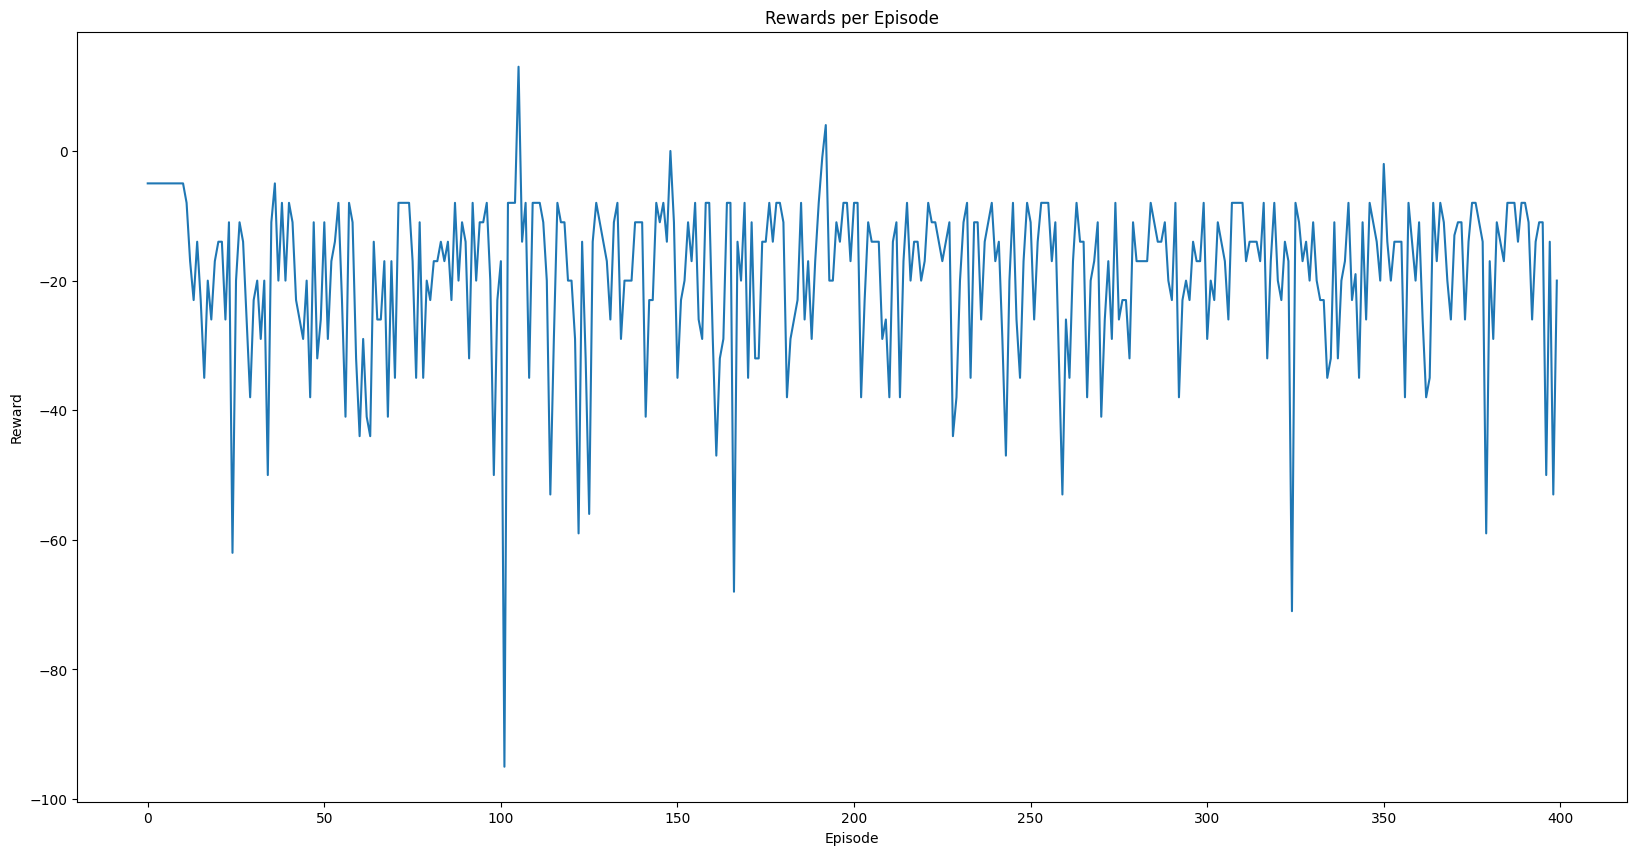

In [76]:
plt.figure(figsize=(20, 10))
plt.plot(rewards_per_episode)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

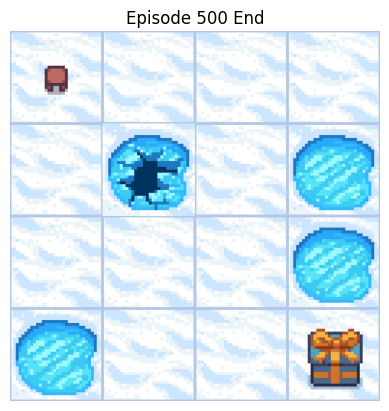

Successfully reached the destination for 18 episodes out of 500


In [94]:
env.reset()
# Visualize the agent's performance
visualize_agent(env, q_table, episodes=500, sleep_time=0, end_sleep_time=0, video_fps=10)

#Clean up the environment
env.close()

In [78]:
def print_env_info(env):
    base_env = env.unwrapped
    nrows, ncols = base_env.desc.shape

    print("=== Frozen Lake Environment Info ===")
    print(f"Map size: {nrows}x{ncols}")
    print(f"Observation space: {base_env.observation_space}")
    print(f"Action space: {base_env.action_space}\n")

    print("Grid layout:")
    for row in base_env.desc:
        print(" ".join(cell.decode('utf-8') for cell in row))

    print("\nFlat index mapping:")
    for i in range(nrows * ncols):
        r, c = divmod(i, ncols)
        print(f"State {i:2d} ({r},{c}): {base_env.desc[r][c].decode('utf-8')}")



env.reset()
print_env_info(env)

=== Frozen Lake Environment Info ===
Map size: 4x4
Observation space: Discrete(16)
Action space: Discrete(4)

Grid layout:
S F F F
F H F H
F F F H
H F F G

Flat index mapping:
State  0 (0,0): S
State  1 (0,1): F
State  2 (0,2): F
State  3 (0,3): F
State  4 (1,0): F
State  5 (1,1): H
State  6 (1,2): F
State  7 (1,3): H
State  8 (2,0): F
State  9 (2,1): F
State 10 (2,2): F
State 11 (2,3): H
State 12 (3,0): H
State 13 (3,1): F
State 14 (3,2): F
State 15 (3,3): G


In [79]:
env.reset()
print(env.render())

[[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]


In [80]:
tile_layout = "\n".join(" ".join(cell.decode('utf-8') for cell in row) for row in env.unwrapped.desc)
state_layout = "\n".join(
    " ".join(f"{r*4+c:2d}" for c in range(4)) for r in range(4)
)

grid_text = (
    f"The 4x4 grid is mapped as follows (state numbers):\n{state_layout}\n\n"
    f"The tile layout of the grid is:\n{tile_layout}\n\n"
)


In [81]:
print(grid_text)

The 4x4 grid is mapped as follows (state numbers):
 0  1  2  3
 4  5  6  7
 8  9 10 11
12 13 14 15

The tile layout of the grid is:
S F F F
F H F H
F F F H
H F F G




In [82]:
env.unwrapped.desc

array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

In [83]:
def is_hole(env, state):
    """Returns True if the given state is a hole ('H') in the FrozenLake map."""
    base_env = env.unwrapped
    desc = base_env.desc
    ncols = desc.shape[1]
    row, col = divmod(state, ncols)
    return desc[row][col] == b'H'


print(is_hole(env, 6))

False


In [84]:
def distance_to_goal(state, goal_state=15, grid_width=4):
    """Returns the Manhattan distance between current state and the goal."""
    row1, col1 = divmod(state, grid_width)
    row2, col2 = divmod(goal_state, grid_width)
    return abs(row1 - row2) + abs(col1 - col2)

print(env.unwrapped.desc.shape[1])

4


In [85]:
distance_to_goal(5)

4

In [86]:
# Overwrite hole and terminal states
for state in range(env.observation_space.n):
    if is_hole(env, state) or state == 15:  # goal is also terminal
        q_table[state] = np.zeros(env.action_space.n)

In [87]:
print(q_table)

[[-14.35181458 -15.30072725 -14.44368221 -14.9538926 ]
 [-14.77584913 -14.90922364  -9.70999386 -15.40768235]
 [-13.18786305 -12.50629276 -10.59457145 -13.5031665 ]
 [ -9.72939667  -8.27284545 -10.76038074 -11.21374229]
 [-10.74715476  -7.5858854  -10.52340141 -14.19608391]
 [  0.           0.           0.           0.        ]
 [ -5.55036096  -6.21138035  -7.92486436 -10.03637254]
 [  0.           0.           0.           0.        ]
 [ -9.39084427  -9.72212434  -7.65214859 -10.80241905]
 [ -8.27698302  -7.24099957  -4.78527347  -5.78213931]
 [ -3.659871    -4.12904494  -3.81689839  -6.95401371]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [ -2.81666831  -4.25        -2.1803802   -4.57161615]
 [ -0.59536026   1.40935846   2.52911207  -0.77965298]
 [  0.           0.           0.           0.        ]]
